<a href="https://colab.research.google.com/github/DebraBeat/Synthetic-Data-Analysis/blob/main/Can_Synthetic_Data_Replace_Real_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can Synthetic Data Replace Real Data

### Goal
The goal of this project is to rigorously evaluate whether synthetic tabular data can replace real data for supervised learning tasks. The primary contribution is empirical: identifying when synthetic data matches/supplements/fails to replace real data.

### Core question
Under what conditions does training on synthetic tabular data achieve comparable performance to training on real tabular data?

## Imports and data loading

In [ ]:
# Standard Imports
!pip install -U kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn methods and classes
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score # For AUPRC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

 # For SMOTE
import imblearn

# For easy loading of data
# To update kagglehub (adds about a quarter minute of runtime and requires
# session restart)
# !pip install -U kagglehub
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For DatasetMetaData
from dataclasses import dataclass

In [ ]:
gimme_some_credit_train = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "brycecf/give-me-some-credit-dataset",
    "cs-training.csv"
)

gimme_some_credit_test = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "brycecf/give-me-some-credit-dataset",
    "cs-test.csv"
)

default_credit_df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "uciml/default-of-credit-card-clients-dataset",
    "UCI_Credit_Card.csv"
)

adult_census_income_df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "uciml/adult-census-income",
    "adult.csv"
)

Using Colab cache for faster access to the 'give-me-some-credit-dataset' dataset.
Using Colab cache for faster access to the 'give-me-some-credit-dataset' dataset.
Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
Using Colab cache for faster access to the 'adult-census-income' dataset.


## Exploratory Data Analyses

### Give Me Some Credit EDA
Note that this is not the dataset proposed in the original paper. That dataset was a replica of a competition, which was in turn a subset of another competition's data. This dataset is a copy of the orgininal competition's data.

Note that `SeriousDlqin2yrs` is the target feature, thus is having no values in
the `test` DataFrame.

In [ ]:
gimme_some_credit_train.drop('Unnamed: 0', axis='columns', inplace=True)
gimme_some_credit_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
gimme_some_credit_test.drop('Unnamed: 0', axis='columns', inplace=True)
gimme_some_credit_test.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [ ]:
gimme_some_credit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [ ]:
gimme_some_credit_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         81400 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    98877 non-null   float64
dtype

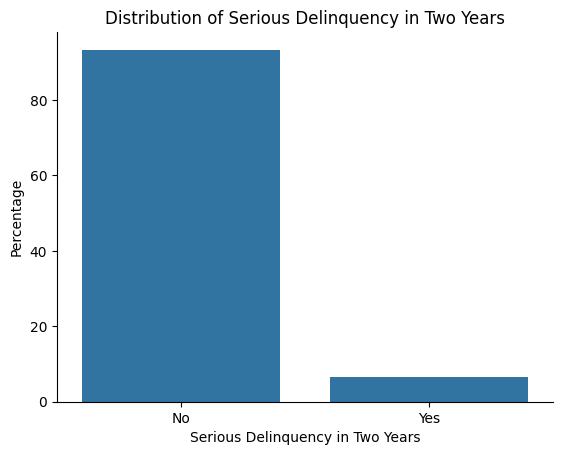

In [ ]:
ax = sns.countplot(x='SeriousDlqin2yrs',
                   data=gimme_some_credit_train,
                   stat='percent');
ax.set_title('Distribution of Serious Delinquency in Two Years')
ax.set_xlabel('Serious Delinquency in Two Years');
ax.set_ylabel('Percentage');
ax.set_xticks([0, 1]);
ax.set_xticklabels(['No', 'Yes']);
sns.despine()

In [ ]:
gimme_some_credit_train[['SeriousDlqin2yrs', 'NumberOfDependents']].groupby('SeriousDlqin2yrs').value_counts()

SeriousDlqin2yrs  NumberOfDependents
0                 0.0                   81807
                  1.0                   24381
                  2.0                   17938
                  3.0                    8646
                  4.0                    2565
                  5.0                     678
                  6.0                     134
                  7.0                      46
                  8.0                      22
                  9.0                       5
                  10.0                      5
                  13.0                      1
                  20.0                      1
1                 0.0                    5095
                  1.0                    1935
                  2.0                    1584
                  3.0                     837
                  4.0                     297
                  5.0                      68
                  6.0                      24
                  7.0                       5
                  8.0                       2
Name: count, dtype: int64

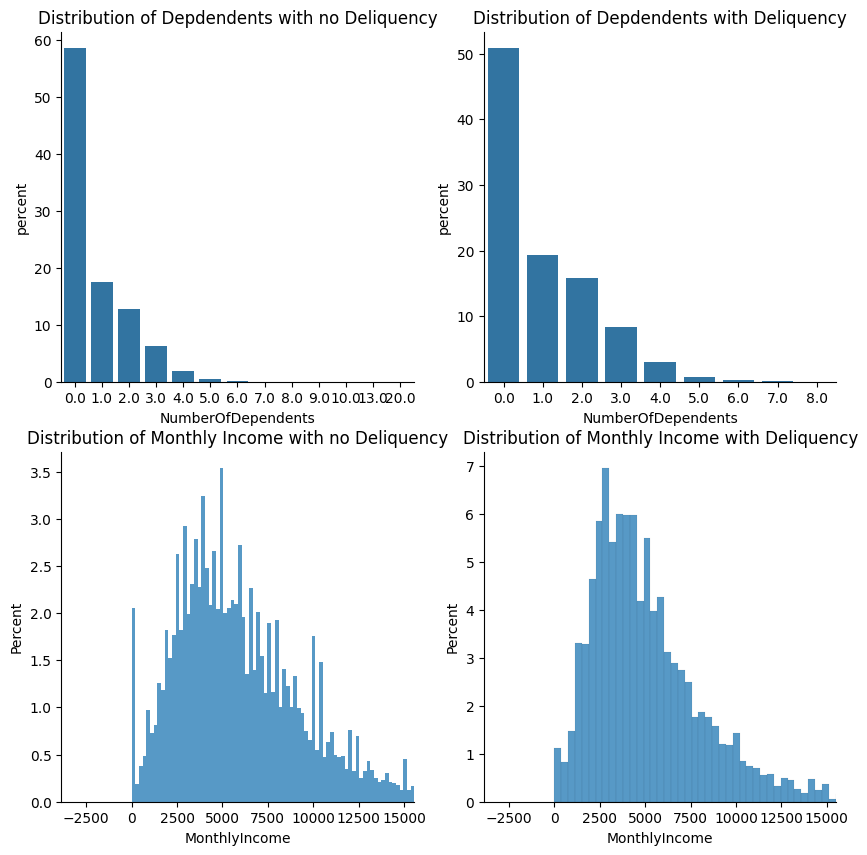

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.countplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 0],
    x='NumberOfDependents',
    stat='percent',
    ax=ax[0, 0]
);

sns.countplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 1],
    x='NumberOfDependents',
    stat='percent',
    ax=ax[0, 1]
);

# Monthly income varies too widely. Let's find outliers
q1, q3 = gimme_some_credit_train['MonthlyIncome'].quantile(0.25), gimme_some_credit_train['MonthlyIncome'].quantile(0.75)
iqr = q3 - q1
low_val, high_val = q1 - 1.5 * iqr, q3 + 1.5 * iqr

sns.histplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 0],
    x='MonthlyIncome',
    stat='percent',
    ax=ax[1, 0]
);

sns.histplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 1],
    x='MonthlyIncome',
    stat='percent',
    ax=ax[1, 1]
);

ax[0, 0].set_title('Distribution of Depdendents with no Deliquency')
ax[0, 1].set_title('Distribution of Depdendents with Deliquency')
ax[1, 0].set_title('Distribution of Monthly Income with no Deliquency')
ax[1, 1].set_title('Distribution of Monthly Income with Deliquency')

# Limit histograms to ignore outliers

ax[1, 0].set_xlim(low_val, high_val)
ax[1, 1].set_xlim(low_val, high_val)

sns.despine();

**Findings:** Our training data had two features which have missing values:
* `NumberOfDependents`
* `MonthlyIncome`

Based on visual inspection, there does not seem to be a correlation between deliquency and the two features. However, statistical testing should be done to confirm this.

Median imputation seems to be appropiate here.

### Default of Credit Clients EDA

In [ ]:
default_credit_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
default_credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

**Findings**: The Default of Credit Clients dataset has no missing values.

### Adult Census Income EDA

In [ ]:
adult_census_income_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
adult_census_income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Findings**: The Adult Census Income dataset has no missing values.

## Set-up, Splitting, Preprocessing, and Cross-Validation
As per sections 2.1, 2.2, and 2.3 of the research protocol document:

1. **Set-up:** We study supervised classification under three training regimes: real-only, synthetic-only, and mixed real-plus-synthetic training. All evaluations are performed on real data that is never used during synthetic data generation.

2. **Splitting:** Each dataset is split into a held-out test set (20%) and a development set (80%). Model selection and evaluation on the development set are performed using repeated stratified K-fold cross-validation. All reported results are averaged across folds and repetitions.

3. **Preprocessing:** Numerical features are standardized using statistics computed on the training portion of each fold. Categorical features are encoded using one-hot encoding. Missing values are imputed using simple strategies (median for numerical features, mode for categorical features). All preprocessing steps are fit exclusively on training data within each fold.



### Set-up

We'll want to encapsulate all the info about our datasets (num cols, cat cols, X_train, X_test, etc in one easy place. This will allow for:
* Decluttering of variable names
* Type-hinting
* Future Iterability

We perform this with the below class. We set up info for experiments first.

In [ ]:
TEST_PROPORTION, DEVELOPMENT_PROPORTION = 0.8, 0.2
SPLITS, REPEATS = 5, 5

# TODO: Synthetic methods and Data Regimes (3.3 and 3.5)

regimes = ['real', 'synthetic', 'mixed']
models = [LogisticRegression(random_state=42),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42)]

In [ ]:
@dataclass
class DatasetMetadata:
  name: str
  dataset: pd.DataFrame
  target_feature_name: str
  num_feature_names: list | str
  cat_feature_names: list | str

  # Initialize all to None
  X_train: pd.DataFrame = None
  X_test: pd.DataFrame = None
  y_train: pd.DataFrame = None
  y_test: pd.DataFrame = None

  def set_splits(self, test_size=0.8, random_state=42) -> None:
    self.X = self.dataset[self.num_feature_names + self.cat_feature_names].copy()
    self.y = self.dataset[self.target_feature_name].copy()

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y,
        test_size=test_size,
        stratify=self.y,
        random_state=random_state
    )

### Splitting
We store instances of our dataset metadata in a list

In [ ]:
ds_md_list = [
    DatasetMetadata(
        name = "Give Me Some Credit",
        dataset = gimme_some_credit_train,
        target_feature_name = "SeriousDlqin2yrs",
        num_feature_names = gimme_some_credit_train.columns.drop(
            "SeriousDlqin2yrs").to_list(),
        cat_feature_names = []
    ),

    DatasetMetadata(
        name = "Default of Credit Clients",
        dataset = default_credit_df,
        target_feature_name = "default.payment.next.month",
        # Note that ID is a nuisance variable, and shouldn't be included.
        # default.payment.next.month is the target feature
        num_feature_names = default_credit_df.drop(
            columns=["ID", "SEX", "EDUCATION", "MARRIAGE",
                     "default.payment.next.month"]).columns.to_list(),
        cat_feature_names = ["SEX", "EDUCATION", "MARRIAGE"]
    ),

    DatasetMetadata(
        name = "Adult Census Income",
        dataset = adult_census_income_df,
        target_feature_name = "income",
        # On the `fnlwgt` feature (final weight)
        # From https://www.kaggle.com/datasets/uciml/adult-census-income/discussion/32698
        # "Its a weight assigned by the Census Bureau. **The idea is that if two
        # samples have the same(or similar) fnlwgt they have similar
        # characteristics, demographically speaking...but it is not standardized
        # across states."
        #
        # Decision: drop variable
        num_feature_names = ["age", "education.num", "capital.gain",
                             "capital.loss", "hours.per.week"],
        cat_feature_names = ["workclass", "education", "marital.status",
                             "occupation", "relationship", "race", "sex",
                             "native.country"]
    )
]

for instance in ds_md_list:
  instance.set_splits()

To test we have coverage of the columns, the differences should be nuisance features

In [ ]:
for instance in ds_md_list:
  col_names = pd.Index(instance.num_feature_names + \
                       instance.cat_feature_names + \
                       [instance.target_feature_name])
  display(instance.dataset.columns.difference(col_names))


Index([], dtype='object')

Index(['ID'], dtype='object')

Index(['fnlwgt'], dtype='object')

### Preprocessing

In [ ]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
     ('standardize', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
     ('encode', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

def preprocess(num_cols: list[str], cat_cols: list[str]) -> ColumnTransformer:
  """
  Create a ColumnTransformer for our data

  Args:
    num_cols (list of str): List of numerical column names to be
            imputed (median) and standardized.
    cat_cols (list of str): List of categorical column names to be
        imputed (most frequent) and one-hot encoded.

  Returns:
    ColumnTransformer: A preprocessor which imputes via median then standardizes
    numerical columns and imputes via mode then one-hot encodes categorical
    columns.
  """

  preprocessor = ColumnTransformer(transformers=[
      ('cat', cat_pipeline, cat_cols),
      ('num', num_pipeline, num_cols)
  ])

  return preprocessor

### Cross-Validation

In [ ]:
from sklearn.base import defaultdict
cv_strategy = RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=REPEATS,
                                      random_state=42)

# Dict to store results of cv tests
results = {}

for model in models:
  model_name = model.__class__.__name__

  for instance in ds_md_list:
    display(f'Currently working on {instance.name} training with {model_name}...')
    preprocessor = preprocess(num_cols=instance.num_feature_names,
                              cat_cols=instance.cat_feature_names)

    model_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", model)
    ])

    scores = cross_val_score(
        model_pipeline,
        instance.X_train,
        instance.y_train,
        scoring = 'roc_auc',
        cv=cv_strategy,
        n_jobs=-1
    )

    mean_score = np.mean(scores)

    if instance.name not in results:
            results[instance.name] = {}
    results[instance.name][model_name] = mean_score

pd.DataFrame(results)

'Currently working on Give Me Some Credit training with LogisticRegression...'

'Currently working on Default of Credit Clients training with LogisticRegression...'

'Currently working on Adult Census Income training with LogisticRegression...'

'Currently working on Give Me Some Credit training with DecisionTreeClassifier...'

'Currently working on Default of Credit Clients training with DecisionTreeClassifier...'

'Currently working on Adult Census Income training with DecisionTreeClassifier...'

'Currently working on Give Me Some Credit training with RandomForestClassifier...'

'Currently working on Default of Credit Clients training with RandomForestClassifier...'

'Currently working on Adult Census Income training with RandomForestClassifier...'

,Give Me Some Credit,Default of Credit Clients,Adult Census Income
LogisticRegression,0.687046,0.720202,0.907900
DecisionTreeClassifier,0.601277,0.606765,0.751326
RandomForestClassifier,0.826711,0.749189,0.888929


## Week 3 - Default of Credit Card Clients